# PID

In [58]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt
from IPython.display import HTML

import numpy as np
import jax.numpy as jnp

from extravaganza.dynamical_systems import PIDGym

from extravaganza.sysid import Predictor, Lifter
from extravaganza.observables import TimeDelayedObservation
from extravaganza.controllers import NonlinearBPC, ConstantController
from extravaganza.rescalers import ADAM, D_ADAM, DoWG
from extravaganza.utils import ylim, render
from extravaganza.experiments import Experiment

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = None
CONTROLLER_SEED = None
SYSID_SEED = None

## System

describe here

## Hyperparameters

In [53]:
name = 'pid'
filename = '../logs/{}.pkl'.format(name)

def get_experiment_args():
    # --------------------------------------------------------------------------------------
    # ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    num_trials = 1
    T = 4000
    T0 = 2000
    reset_condition = lambda t: t % 200 == 0
    use_multiprocessing = False
    render_every = None

    # --------------------------------------------------------------------------------------
    # --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
    # --------------------------------------------------------------------------------------

    dl = 8  # dim to lift to
    
    initial_Kp = 0.1  # initial values for K
    initial_Ki = 0.05
    initial_Kd = 0.05
    initial_control = jnp.array([initial_Kp, initial_Ki, initial_Kd])
    du = initial_control.shape[0]

    def apply_control(control, system): 
        system.pid.Kp = system.pid.Kp.at[0].set(control[0].item())     
        system.pid.Ki = system.pid.Ki.at[0].set(control[1].item())     
        system.pid.Kd = system.pid.Kd.at[0].set(control[2].item())        
        
    env_name = 'CartPole-v1'  
    # env_name = 'MountainCarContinuous-v0'

    system_args = {
        'env_name': env_name,
        'apply_control': apply_control,
        'control_dim': du,  # because CartPole
        'repeat': 10,
        'gym_repeat': 1,
        'max_episode_len': 300,
        'seed': SYSTEM_SEED,
        'Kp': initial_Kp,
        'Ki': initial_Ki,
        'Kd': initial_Kd
    }
    make_system = lambda : PIDGym(**system_args)
    observable = TimeDelayedObservation(hh = 3, control_dim=du, use_states=False, use_costs=True, use_controls=True); assert not observable.use_states; do = observable.hh * (1 * observable.use_costs + du * observable.use_controls)

    # --------------------------------------------------------------------------------------
    # ------------------------    LIFT/SYSID HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    sysid_args = {
        'obs_dim': do,
        'control_dim': du,
        'initial_control': initial_control,
        
        'max_traj_len': int(1e6),
        'exploration_scale': 1.,

        'depth': 8,
        'num_epochs': 150,
        'batch_size': 1024,
        'lr': 0.001,
        
        'seed': SYSID_SEED,
    }

    # --------------------------------------------------------------------------------------
    # ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    h = 3  # controller memory length (# of w's to use on inference)
    m_update_rescaler = lambda : ADAM(0.003, betas=(0.9, 0.999))
    m0_update_rescaler = lambda : ADAM(0.003, betas=(0.9, 0.999))
    k_update_rescaler = lambda : ADAM(0.00, betas=(0.9, 0.999))

    nonlinear_bpc_args = {
        'h': h,  
        'method': 'REINFORCE',
        'initial_scales': (0., 0.1, 0.),  # M, M0, K   (uses M0's scale for REINFORCE)
        'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
        'T0': T0,
        'bounds': ([0, 0, 0], [1, 1, 1]),
        'initial_u': initial_control,
        'decay_scales': True,
        'use_tanh': False,
        'use_stabilizing_K': True,
        'seed': CONTROLLER_SEED
    }

    make_controllers = {
#         '0.1/0.0/0.0': lambda sys: ConstantController([0.1, 0., 0.], du),
#         '0.1/0.0/0.5': lambda sys: ConstantController([0.1, 0., 0.5], du),
#         '0.1/0.05/0.0': lambda sys: ConstantController([0.1, 0.05, 0.], du),
#         '0.1/0.05/0.5': lambda sys: ConstantController([0.1, 0.05, 0.5], du),
#         '0.2/0.0/0.5': lambda sys: ConstantController([0.2, 0., 0.5], du),

        'Linear': lambda sys: NonlinearBPC(sysid=Predictor(epsilon=0, norm_fn=observable.norm_fn, **sysid_args), **nonlinear_bpc_args),
#         'Nonlinear': lambda sys: NonlinearBPC(sysid=Predictor(epsilon=0.1, norm_fn=observable.norm_fn, **sysid_args), **nonlinear_bpc_args),
        'Lifted': lambda sys: NonlinearBPC(sysid=Lifter(method='nn', state_dim=dl, sysid_every=3, **sysid_args), **nonlinear_bpc_args)
    }
    experiment_args = {
        'make_system': make_system,
        'make_controllers': make_controllers,
        'observable': observable,
        'num_trials': num_trials,
        'T': T,
        'reset_condition': reset_condition,
        'reset_seed': SYSTEM_SEED,
        'use_multiprocessing': use_multiprocessing,
        'render_every': render_every,
    }
    return experiment_args

## actually run the thing :)

In [54]:
# run
experiment = Experiment(name)
stats = experiment(get_experiment_args)

INFO: (EXPERIMENT) --------------------------------------------------
INFO: (EXPERIMENT) ----------------- TRIAL 0 -----------------------
INFO: (EXPERIMENT) --------------------------------------------------

INFO: (EXPERIMENT): testing Linear
 50%|████████████████████████▍                        | 1995/4000 [00:12<00:13, 144.96it/s, control=[0.         0.26553765 0.2320767 ], cost=0.00236]INFO: (PREDICTOR): ending sysid phase at step 1998
INFO: training!

0it [00:00, ?it/s]
INFO: we WILL use the stabilizing controller K with ||A-BK||=0.8723136186599731
 50%|████████████████████████▉                         | 1995/4000 [00:12<00:13, 144.96it/s, control=[0.01754946 0.         0.02704534], cost=0.0617]

|A| 0.9630494713783264
|A-BK| 0.8723136186599731
|B| 0.5350618


100%|██████████████████████████████████████████████████| 4000/4000 [01:05<00:00, 60.71it/s, control=[0.03809142 0.         0.13280717], cost=4.33e-5]
INFO: 
INFO: (EXPERIMENT): testing Lifted
 50%|████████████████████████▉                         | 1991/4000 [00:12<00:12, 159.46it/s, control=[0.16065174 0.         0.        ], cost=0.0151]INFO: (LIFTER): ending sysid phase at step 1998
INFO: training!
INFO: mean loss for past 25 epochs was 0.5898745656013489
INFO: mean loss for past 25 epochs was 0.5390269124507904
INFO: mean loss for past 25 epochs was 0.4549490809440613
INFO: mean loss for past 25 epochs was 0.36224049687385557
INFO: mean loss for past 25 epochs was 0.2667793834209442
INFO: mean loss for past 25 epochs was 0.20532388508319854
INFO: mean loss for past 25 epochs was 0.14894385308027266
INFO: we will NOT use the stabilizing controller K with ||A-BK||=1.2427986860275269
 50%|█████████████████████████▍                         | 1991/4000 [00:14<00:12, 159.46it/s, control=

|A| 0.9998660683631897
|A-BK| 1.2427986860275269
|B| 0.0041453787


100%|██████████████████████████████████████████████████| 4000/4000 [00:42<00:00, 95.09it/s, control=[0.02887747 0.         0.17086202], cost=9.18e-5]
INFO: 
ERROR: (STATS) failed to aggregate only 1 stat
ERROR: (STATS) failed to aggregate only 1 stat
INFO: (EXPERIMENT) done! The entire experiment took 108.00786195893306 seconds


In [55]:
# save args and stats!  --  note that to save the args, we actually save the `get_args` function. we can print the 
#                           source code later to see the hyperparameters we chose
experiment.save(filename)

INFO: (EXPERIMENT) saved experiment to `../logs/pid.pkl`


## Visualization
We keep track of the useful information through `Stats` objects, which can `register()` a variable to keep track of (which it does via calls to `update()`) and which can be aggregated via `Stats.aggregate()` for mean and variance statistics. 

We define below a plotting arrangement that plots all the desired quantities from both the system and controller.

In [56]:
def plot_pid(experiment: Experiment):
    assert experiment.stats is not None, 'cannot plot the results of an experiment that hasnt been run'
    all_stats = experiment.stats
    
    # clear plot and calc nrows
    plt.clf()
    n = 5
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 6 * nrows))

    # plot system stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            print('WARNING: {} had no stats'.format(method))
            continue
        stats.plot(ax[0, 0], 'P', label=method)
#         stats.plot(ax[0, 1], 'ws', label=method)
        stats.plot(ax[1, 0], 'us', label=method)
        stats.plot(ax[1, 1], 'Kp', label=method + ' Kp')
        stats.plot(ax[1, 1], 'Kd', label=method + ' Kd')

        stats.plot(ax[2, 0], 'rewards', label=method)
        stats.plot(ax[2, 1], 'avg rewards since reset', label=method)

        stats.plot(ax[3, 0], '||A||_op', label=method)
        stats.plot(ax[3, 1], '||B||_F', label=method)
        stats.plot(ax[4, 0], '||A-BK||_op', label=method)
        stats.plot(ax[4, 1], 'cost diffs', label=method)
        i_ax = ax[n + i // 2, i % 2]
        stats.plot(ax[0, 1], 'disturbances', label=method)
        stats.plot(i_ax, 'K @ state', label='K @ state')
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w')
        stats.plot(i_ax, 'M0', label='M0')
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('error'); _ax.legend()
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend()
    _ax = ax[1, 0]; _ax.set_title('controls'); _ax.legend()
    _ax = ax[1, 1]; _ax.set_title('state'); _ax.legend()
    
    _ax = ax[2, 0]; _ax.set_title('instantaneous rewards'); _ax.legend()
    _ax = ax[2, 1]; _ax.set_title('avg rewards since last reset'); _ax.legend()
    
    _ax = ax[3, 0]; _ax.set_title('||A||_op'); _ax.legend()
    _ax = ax[3, 1]; _ax.set_title('||B||_F'); _ax.legend()
    
    _ax = ax[4, 0]; _ax.set_title('||A-BK||_op'); _ax.legend()
    _ax = ax[4, 1]; _ax.set_title('cost diffs'); _ax.legend()
    pass

### Plot

<Figure size 640x480 with 0 Axes>

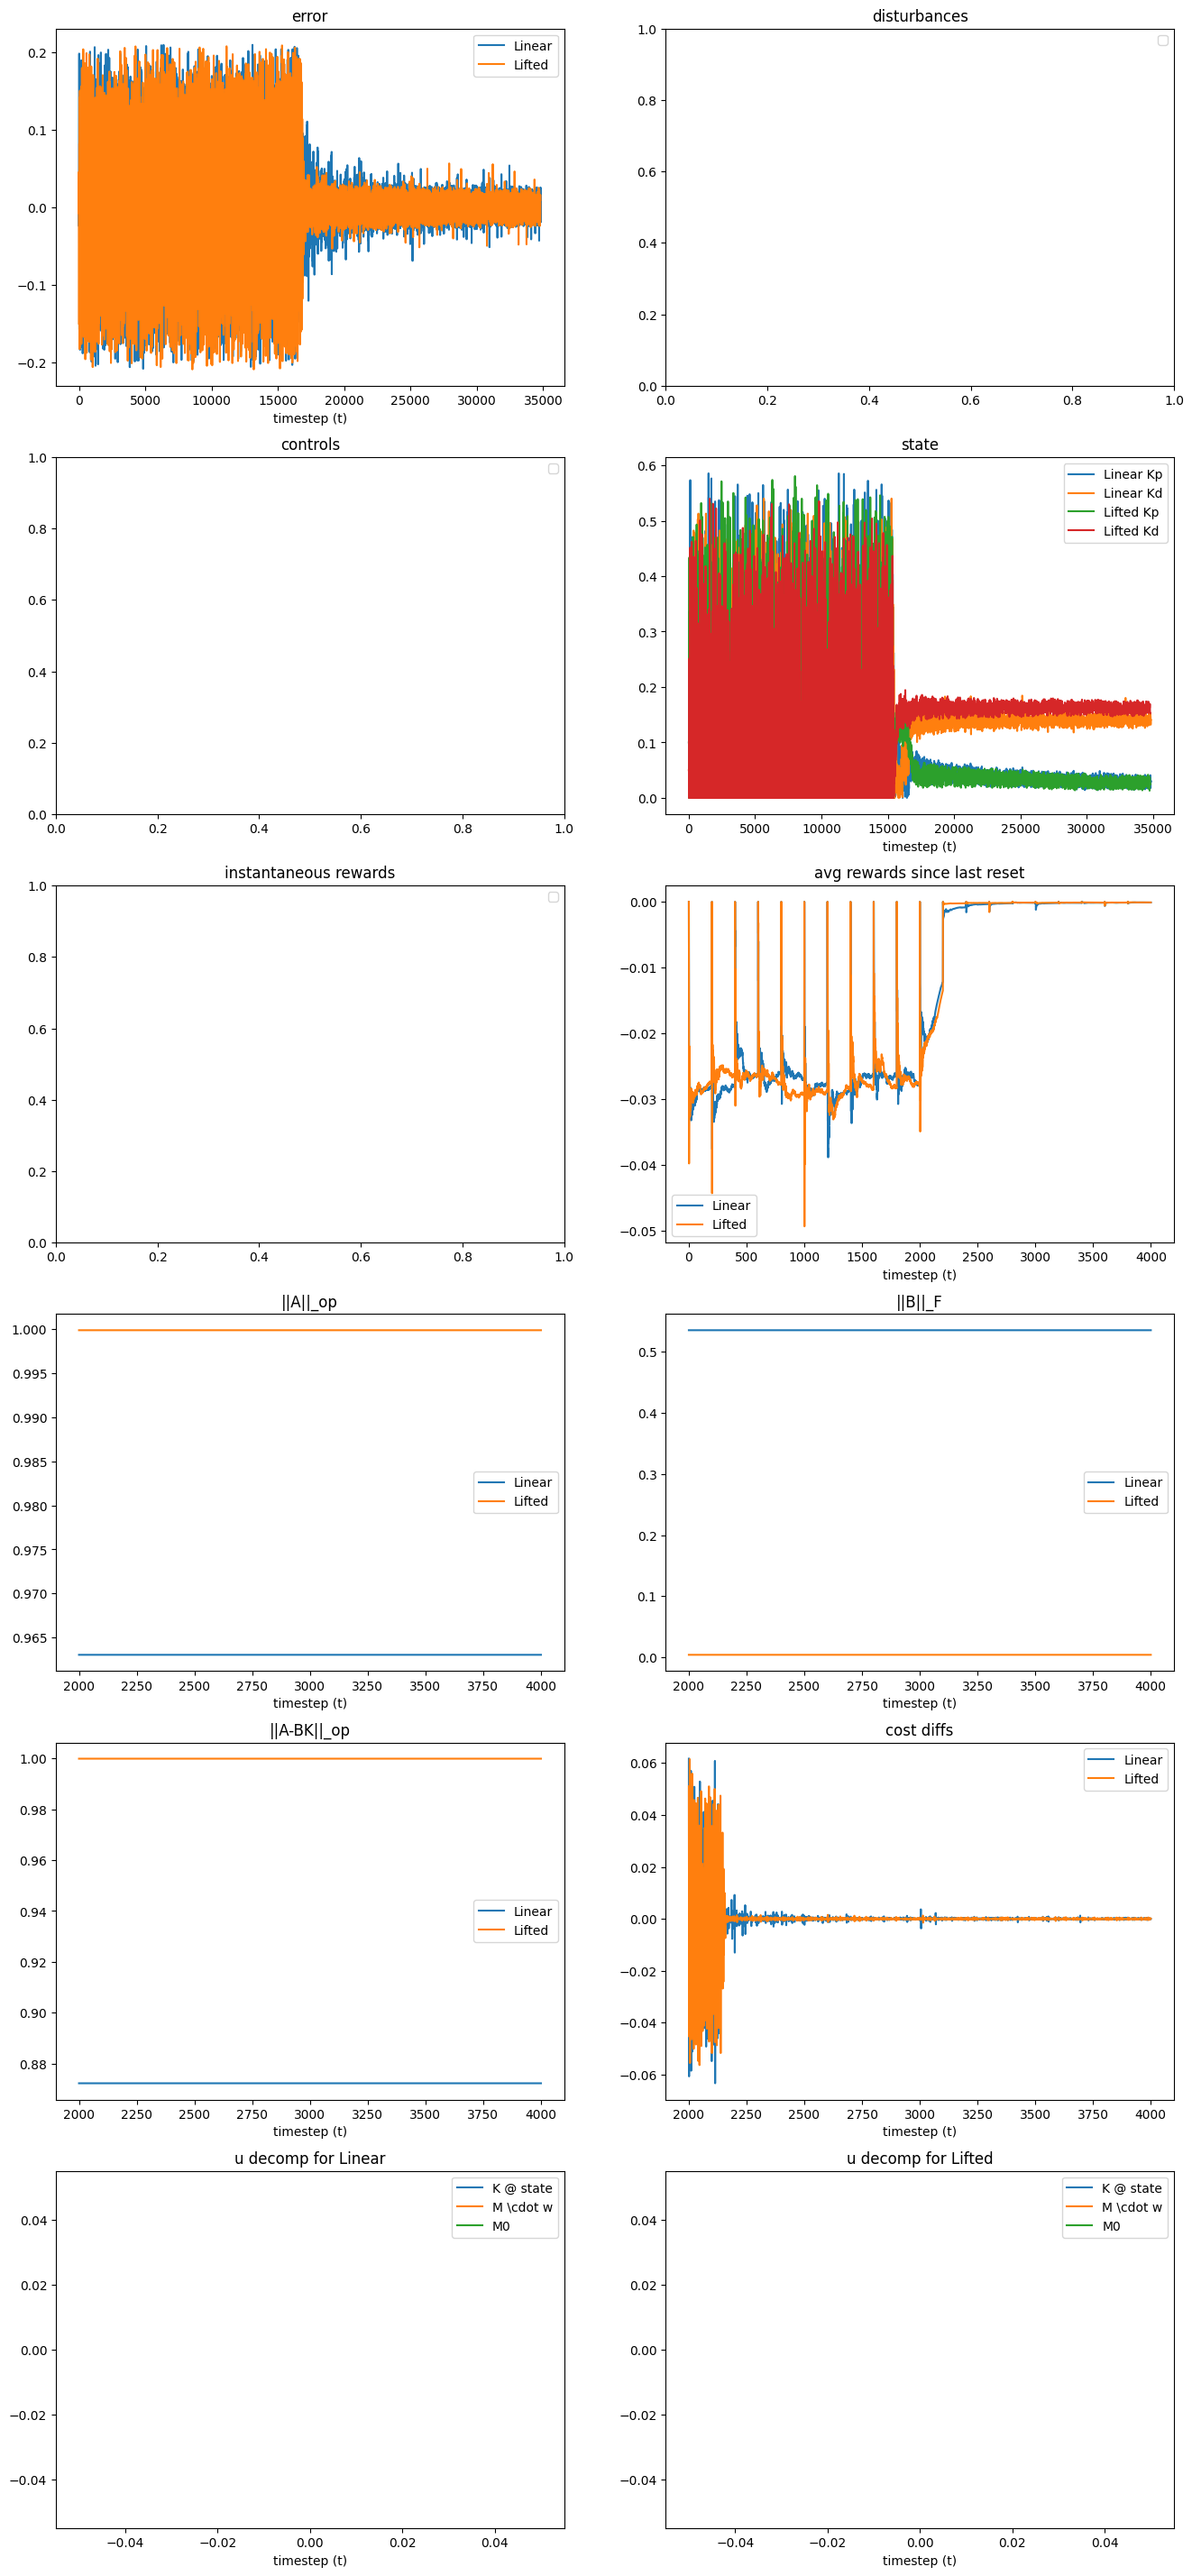

In [57]:
plot_pid(experiment)
# # plot
# from copy import deepcopy
# e = deepcopy(experiment)
# e.stats = {k: s[4100:] for k, s in e.stats.items() if k not in ['No Lift', 'RBPC']}
# plot_pid(e)

### Dynamic Plot

In [ ]:
# dynamic plot
anim = render(experiment, 'Kp', 'rewards', sliderkey='us', save_path=None, duration=5)
vid = anim.to_html5_video()
HTML(vid)